In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
#pip install num2words

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import re
import seaborn as sns

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from num2words import num2words
import emoji
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', header=None)
val = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', header=None)

dataset = [train, val]

In [57]:
stop_words = stopwords.words('english')
for df in dataset:
    df.columns = ['id', 'source', 'target', 'text']
    df.text = df.text.str.lower()
    df.text = df.text.astype('str')
    df.text = df.text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) 
    
    df = df[~df.isnull()]
    df = df[~df.duplicated()]
    
    df.text = df['text'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
    df.text = df['text'].apply(lambda x: emoji.demojize(x, language='en'))
    for w in df.text:
        if w.isdigit():
            w = num2words(w)
    df.text = ' '.join(w)


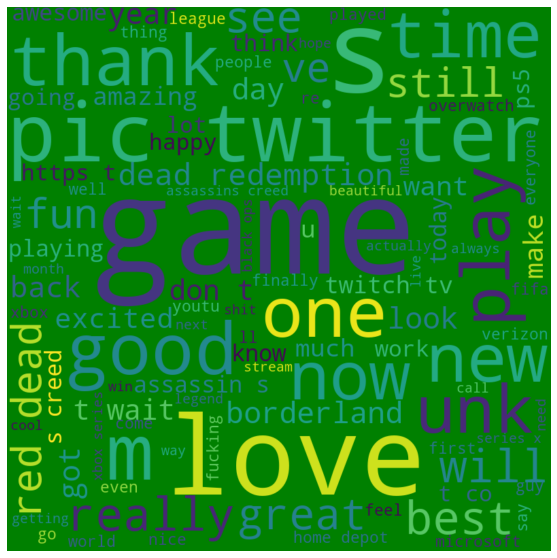

In [58]:
word_cloud_textP = ''.join(train[train["target"]=="Positive"]['text'])
wordcloud = WordCloud(max_font_size=200,
                     width=800, height=800,max_words=100,
                     background_color='green').generate(word_cloud_textP)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

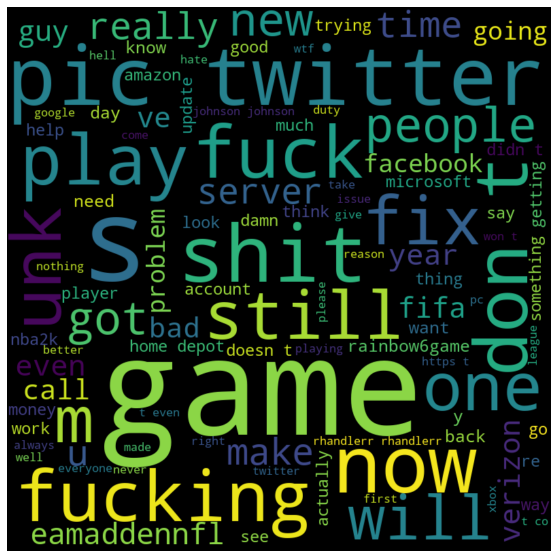

In [59]:
word_cloud_textN = "".join(train[train['target']=='Negative']['text'])
wordcloud2 = WordCloud(max_font_size=200,
                      width=800, height=800,max_words=100,
                      background_color='black').generate(word_cloud_textN)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

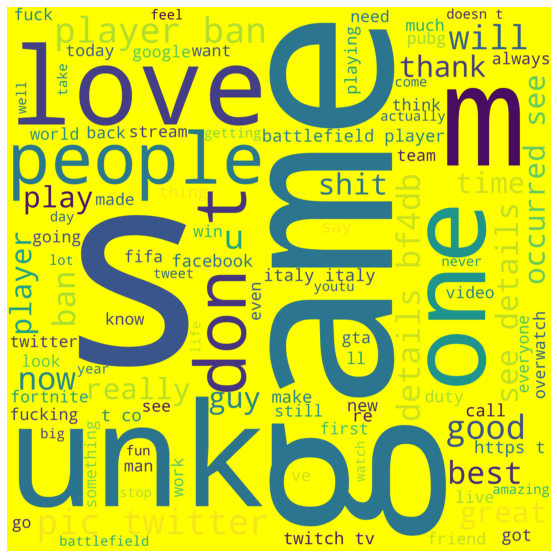

In [60]:
word_cloud_textIrr = "".join(train[train['target']=='Irrelevant']['text'])
wordcloud3 = WordCloud(width = 800, height=800,
                      max_words=100, scale=10, background_color='yellow').generate(word_cloud_textIrr)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.show()

In [61]:
plot1 = train.groupby(by=['source', 'target']).count().reset_index()
plot1.head()

,source,target,id,text
0,Amazon,Irrelevant,192,192
1,Amazon,Negative,576,576
2,Amazon,Neutral,1236,1236
3,Amazon,Positive,312,312
4,ApexLegends,Irrelevant,192,192


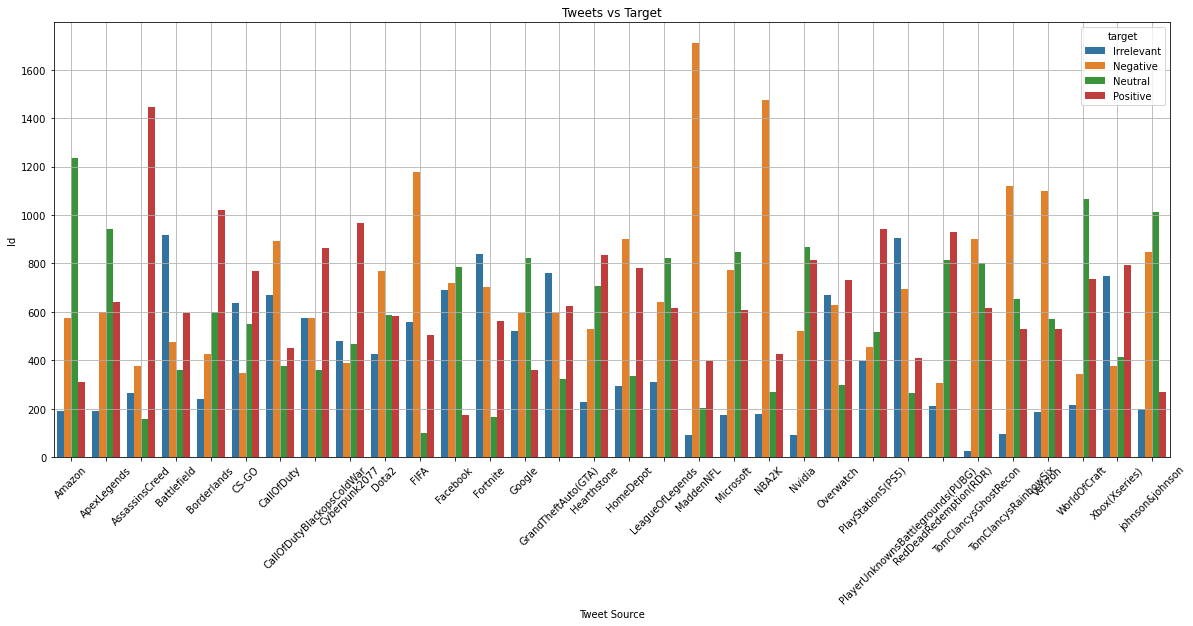

In [62]:
plt.figure(figsize=(20, 8))
sns.barplot(data=plot1, x = 'source', y='id', hue='target')
plt.xlabel('Tweet Source')
plt.ylabel('Id')
plt.xticks(rotation=45)
plt.grid()
plt.title('Tweets vs Target')
plt.show()

In [63]:
target_balance = round((train['target'].value_counts()/len(train))*100, 2)
print(target_balance)

Negative      30.18
Positive      27.89
Neutral       24.53
Irrelevant    17.39
Name: target, dtype: float64


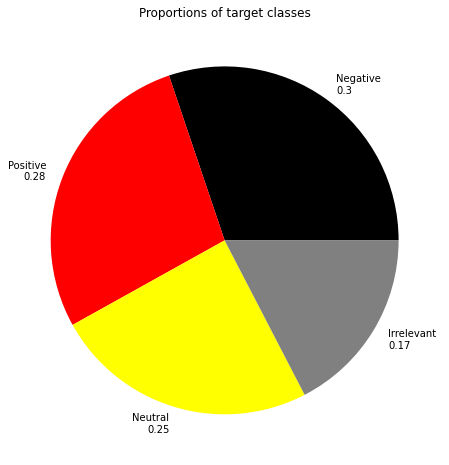

In [64]:
target_balance = train['target'].value_counts()
plt.figure(figsize=(8, 8))

plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(train), 2)}' for idx in target_balance.index], 
        colors=['black', 'red', 'yellow', 'gray'])
plt.title('Proportions of target classes')
plt.show()

In [65]:
lemmatizer = WordNetLemmatizer()
for df in dataset:
    df.text = df['text'].apply(lambda x: lemmatizer.lemmatize(x))

In [66]:
X = train.drop('target', axis=1)
y = train.target

In [67]:
X_dum = pd.get_dummies(X.source)
X = pd.concat([X, X_dum], axis=1)
X.drop('source', axis=1, inplace=True)
X.drop('id', axis=1, inplace=True)

val_dum = pd.get_dummies(val.source)
val = pd.concat([val, val_dum], axis=1)
val.drop('source', axis=1, inplace=True)
val.drop('id', axis=1, inplace=True)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [69]:
# from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase = False, max_features=8000,
                            min_df = 10, tokenizer=nltk.word_tokenize, ngram_range=(1,4))

In [120]:
vectorizer2 = CountVectorizer(lowercase = False, max_features=8000,
                            min_df = 10, tokenizer=nltk.word_tokenize, ngram_range=(1,4))

In [98]:
textTrain = vectorizer.fit_transform(X_train.text)
textVal = vectorizer.transform(X_test.text)

textTrain = pd.DataFrame.sparse.from_spmatrix(textTrain, columns = vectorizer.get_feature_names_out())
textVal = pd.DataFrame.sparse.from_spmatrix(textVal, columns = vectorizer.get_feature_names_out())

In [99]:
lr = LogisticRegression(C=1, solver="liblinear",max_iter=250)
lr.fit(textTrain, y_train)
preds = lr.predict(textVal)
print(accuracy_score(y_test, preds)*100)

69.59898239271607


In [100]:
valX = val.drop('target', axis=1)
valY = val.loc[:, 'target']

In [101]:
text_valX = vectorizer.transform(valX.text)
text_valX = pd.DataFrame.sparse.from_spmatrix(text_valX, columns = vectorizer.get_feature_names_out())

predsVal = lr.predict(text_valX)
print(f'The accuracy is {accuracy_score(valY, predsVal)*100} on test data')

The accuracy is 80.9 on test data


In [102]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=8)
abc = AdaBoostClassifier(base_estimator=dtc, n_estimators=200, learning_rate=1)
rfc = RandomForestClassifier(n_estimators=200, max_depth=8, oob_score=True)
lr2 = LogisticRegression(C=0.9, solver="liblinear",max_iter=250)

models=[dtc, rfc, abc, lr2]

In [132]:
val_acc = []
test_acc = []
def ensemble_accuracy(model):

    print(model)
    model.fit(textTrain, y_train)
    preds_ensemble = model.predict(textVal)
    val_acc.append(accuracy_score(y_test, preds_ensemble)*100)
    predsVal_ensemble = model.predict(text_valX)
    test_acc.append(accuracy_score(valY, predsVal_ensemble)*100)





In [119]:
for model in models:
    ensemble_accuracy(model)

df_results = {'model' : ['Decision Tree', 'Random Forest', 'Ada Boost', 'Logistic Regression'],
              'val_acc' : [round(acc,2) for acc in val_acc],
              'test_acc': [acc2 for acc2 in test_acc]}
df = pd.DataFrame.from_dict(df_results)
df



,model,val_acc,test_acc
0,Decision Tree,39.18,40.2
1,Random Forest,44.59,46.7
2,Ada Boost,70.30,84.5
3,Logistic Regression,69.24,80.4


Decison tree performs poorly on text data sentiment analysis since the vectorized words cannot be split as features and we do not find any reasonable information gain.

We can see the data can be seperated as vectors using either Logistic Regression or Ada Boost which perform better on the test data.

In [133]:
textTrain = vectorizer2.fit_transform(X_train.text)
textVal = vectorizer2.transform(X_test.text)

textTrain = pd.DataFrame.sparse.from_spmatrix(textTrain, columns = vectorizer2.get_feature_names_out())
textVal = pd.DataFrame.sparse.from_spmatrix(textVal, columns = vectorizer2.get_feature_names_out())

text_valX = vectorizer2.transform(valX.text)
text_valX = pd.DataFrame.sparse.from_spmatrix(text_valX, columns = vectorizer2.get_feature_names_out())

In [134]:
for model in models:
    ensemble_accuracy(model)

df_results2 = {'model' : ['Decision Tree', 'Random Forest', 'Ada Boost', 'Logistic Regression'],
              'val_acc' : [round(acc,2) for acc in val_acc],
              'test_acc': [acc2 for acc2 in test_acc]}


DecisionTreeClassifier(max_depth=8)
RandomForestClassifier(max_depth=8, n_estimators=200, oob_score=True)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8),
                   learning_rate=1, n_estimators=200)
LogisticRegression(C=0.9, max_iter=250, solver='liblinear')


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [129]:
df_results2

{'model': ['Decision Tree',
  'Random Forest',
  'Ada Boost',
  'Logistic Regression'],
 'val_acc': [39.11, 43.19, 75.36, 74.41, 39.1, 44.32, 75.02, 74.41],
 'test_acc': [39.5, 45.0, 87.3, 87.0, 39.5, 45.800000000000004, 86.9, 87.0]}

In [135]:
df2 = pd.DataFrame.from_dict(df_results2)
df2

,model,val_acc,test_acc
0,Decision Tree,39.10,39.5
1,Random Forest,42.70,44.3
2,Ada Boost,75.56,85.9
3,Logistic Regression,74.41,87.0
